In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", palette="pastel")


import warnings
warnings.filterwarnings('ignore')

from utils import read_table_from_zip, train_test_split

## Load data

In [44]:
# !wget -nc https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/raw/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Data.7z
# !7z x RLF_Prediction_ITU_AIML_Challenge_Data.7z -aos RLF_Prediction_ITU_AIML_Challenge_Data/RegionA.zip

# Example read for RL-KPIS
#main df

rl_kpis = read_table_from_zip("rl-kpis.tsv")
met_forecast = read_table_from_zip("met-forecast.tsv")
met_real = read_table_from_zip("met-real.tsv")
# met_stations = read_table_from_zip("met-stations.tsv")
# rl_sites = read_table_from_zip("rl-sites.tsv")
distances = read_table_from_zip("distances.tsv")


print(f"rl_kpis.shape: {rl_kpis.shape}")
print(rl_kpis.datetime.min(), rl_kpis.datetime.max())
rl_kpis.head()

rl_kpis.shape: (1992986, 18)
2018-12-31 00:00:00 2020-12-25 00:00:00


,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False


## Data explanation

type -  It represents the radio link equipment vendor type.
datetime -  The date and timestamps from 2nd January of 2019 to 31st December 2019. The measurements are taken at 12.00 am for each date and for the most of the radio link sites

tip - This feature represents the end-points of the link in the site. The end-point is the entry and exit point of the radio link to the sites. It is in different locations such as near the station or far from the station. The link access entry points has no significant effect on the radio link failure event

mlid - The mini-link id for each site RL. It is a market-leading microwave family for cost-efficient mobile transport networks. It’s a microwave cell that enables the 5g ubiquitous transport. This feature represents the id of the microwave mini-link device of the site no. A site-no may have multiple mini-link device. This is the reason behind the multiple entry of the site-id in the dataset where Mlid are unique for each mini link devices

mw_connection_no - This feature represents the site no for the 5g radio link site

site_id -This feature represents the site no for the 5g radio link sites. There are approximately 1387 site no in the dataset. The sites are the area where the 5g network antennas and the devices are situated.

card_type - A modem card is an internal type of modem that is plugged into the PCI slot. A Radio Link modem is a communications device that allows antenna to transmit data wirelessly. There are 5 different types of modem cards in the dataset. The feature doesn’t have any correlation with the radio link failure event as the different card types represents the different card provider.

adaptive_modulation  - Adaptive Modulation is a technique which allows a radio link to change its speed as conditions in the network changes. The adaptive modulation for the RL sites are enabled or disabled which doesn’t have the correlation with the radio link failure.

freq_band - This features represents the standalone 5g (millimeter wave) frequency bands which are divided into five bands (f1,f2,f3,f4,f5). The frequencies are 26,24,39,28 (GHz) and commonly named (LMDS,Kband, ka-band, ka-band) respectively.

severaly_error_second - This feature represents the count of the 1 second period time where the RL error occurs with more than 30 % damaged of the RL frame.

error_second - Count of one second period with error in the link

unavail_second - The RL operation disruption in seconds. The duration of the RL unavailable operation duration in second.

avail_time -The total operation time of the network for one day in seconds. The measurement of the error seconds are deducted from the available time.

bbe - Background Bit error (BBE) represents the number of bit error in a unit time. It is the number of bit error divided by the total transmitted bit for each link. This is the indicator of the performance degradation in each link in the dataset.

rxlevmax - This represents the transmission energy level that is received by the radio links.

capacity - This feature is the RL transmission capacity of each link which is represented in Mb/s.

modulation - This feature represents the Quadrature Amplitude Modulation (QAM) that is deployed for the radio links. It is a method of combining two amplitude-modulated (AM) signals into a single channel, thereby doubling the effective bandwidth. The microwave carrier modulation ranges from 16 QAM to 2048 QAM.

rlf - It represents the radio link failure event that is occurred for each link. It is shown by True or False. The target variable for the dataset = Radio Link Failure event (target)


## Another dfs

met_forecast - The weather forecast data contains entry from ’02-01-2019’ to ’31-12-2019’ of 96 weather stations

met_real - The weather forecast data contains entry from ’01-01-2019’ to ’31-12-2019’ of 112 weather stations with of each hour of the day with station-no.

met_stations - The data-set contains spatial features of the weather stations

rl_sites -The data-set contains spatial features of the Radio link sites.

distance - The distance matrix represents the distance between the weather station and the radio link tower site.

In [4]:
# Firstly, only get unique entry identifiers and RLF column.
# For rl-kpis, unique entry identifiers are 'datetime', 'site_id' and 'mlid'.
df_labels = rl_kpis[["datetime", "site_id", "mlid"]]
df_labels.head()

,datetime,site_id,mlid
0,2018-12-31,RL_;ABDV,A0BE
1,2018-12-31,RL_;ABDV,A0BI
2,2018-12-31,RL_;ABDV,A5AB
3,2018-12-31,RL_;ABDV,A8CQ
4,2018-12-31,RL_;ABDV,A8DQ


In [5]:
df_labels.groupby(['site_id',"mlid"],as_index=False).agg({"datetime":"count"})

,site_id,mlid,datetime
0,RL_;ABDV,A0BE,701
1,RL_;ABDV,A0BI,702
2,RL_;ABDV,A5AB,702
3,RL_;ABDV,A8CQ,708
4,RL_;ABDV,A8DQ,708
...,...,...,...
3685,RL_bKZCQ,A6NA,708
3686,RL_bKZCQ,A7DJ,143
3687,RL_bKZCQ,A8FJ,231
3688,RL_bKZCQ,A8HV,231


In [6]:
rl_kpis.rlf.replace({False:0,True:1},inplace=True)

In [7]:
cond1 = rl_kpis["mlid"] == "A8HV"
cond2 = rl_kpis["site_id"] == "RL_bKZCQ"
rl_kpis[cond1 & cond2].head()

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
1341630,NEC,2020-04-30,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-29.2,495.0,2048QAM*,0
1344516,NEC,2020-05-01,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-29.3,495.0,2048QAM*,0
1347394,NEC,2020-05-02,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-29.2,495.0,2048QAM*,0
1350265,NEC,2020-05-03,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-29.3,495.0,2048QAM*,0
1353147,NEC,2020-05-04,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-29.7,495.0,2048QAM*,0


In [8]:
def plot_ts(col: str, target: str, sample: int =20000):
    test_data = rl_kpis[[col, target]].sample(20000).reset_index(drop=True)

    plt.plot(test_data[col].to_list(), label='Time Series')
    anomalies = test_data[test_data[target] == 1]
    plt.scatter(anomalies.index, anomalies[col], color='red', label='Anomalies', s=10)

    plt.xlabel('Index')
    plt.ylabel('BBE Value')
    plt.legend()
    plt.show()

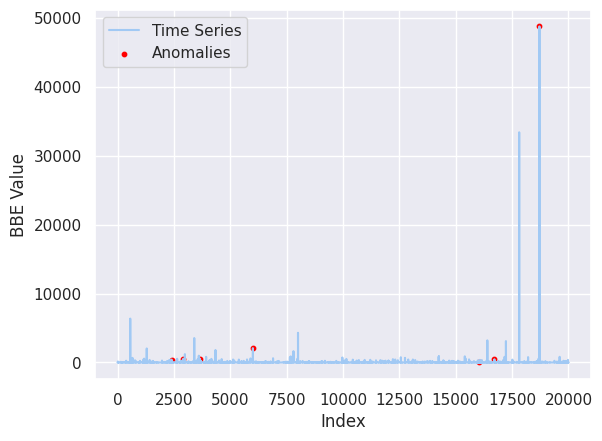

In [9]:
plot_ts("bbe","rlf",sample=5000)

In [57]:
df_final = pd.read_csv("data/turkcell/final_preprocessed_df_train.csv")

In [58]:
df_final_test = pd.read_csv("data/turkcell/final_preprocessed_df_test.csv")

In [ ]:

model = 